In [1]:
import pandas as pd
from datetime import datetime, timedelta

## Load csv files

In [2]:
data_last = pd.read_csv("data_last.csv")
data_last.date = pd.to_datetime(data_last.date, format="%Y-%m-%d")
data_last.head()

,ticker,date,last
0,1332 JT,2017-08-16,562.12
1,1332 JT,2017-08-17,560.36
2,1332 JT,2017-08-18,553.32
3,1332 JT,2017-08-21,544.53
4,1332 JT,2017-08-22,535.73


In [3]:
data_mkt_cap = pd.read_csv("data_mkt_cap.csv")
data_mkt_cap.date = pd.to_datetime(data_mkt_cap.date, format="%Y-%m-%d")
data_mkt_cap.head()

,ticker,date,mkt_cap
0,1332 JT,2017-08-16,199642.95
1,1332 JT,2017-08-17,199018.09
2,1332 JT,2017-08-18,196518.64
3,1332 JT,2017-08-21,193394.34
4,1332 JT,2017-08-22,190270.04


In [4]:
data_sector = pd.read_csv("data_sector.csv")
data_sector.head()

,ticker,bics_sector
0,1332 JT,"Consumer, Non-cyclical"
1,1333 JT,"Consumer, Non-cyclical"
2,1334 JT,"Consumer, Non-cyclical"
3,1605 JT,Energy
4,1721 JT,Industrial


In [5]:
data_volume = pd.read_csv("data_volume.csv")
data_volume.date = pd.to_datetime(data_volume.date, format="%Y-%m-%d")
data_volume.head()

,ticker,date,volume
0,1332 JT,2017-08-16,1641300.0
1,1332 JT,2017-08-17,1247700.0
2,1332 JT,2017-08-18,1505800.0
3,1332 JT,2017-08-21,2046200.0
4,1332 JT,2017-08-22,2409300.0


## Task 1

Compose a stock index using market cap weight, set it to 1000 point on 2020-01-06, and make a line plot

In [6]:
def calculate_index(date, df_mkt_cap):
    data = df_mkt_cap[df_mkt_cap.date==date].dropna()
    total_mkt_cap = data.mkt_cap.sum()
    data["weight"] = data["mkt_cap"].apply(lambda x: x / total_mkt_cap * 1000)
    return data

In [7]:
df = calculate_index(datetime(2020, 1, 6), data_mkt_cap)

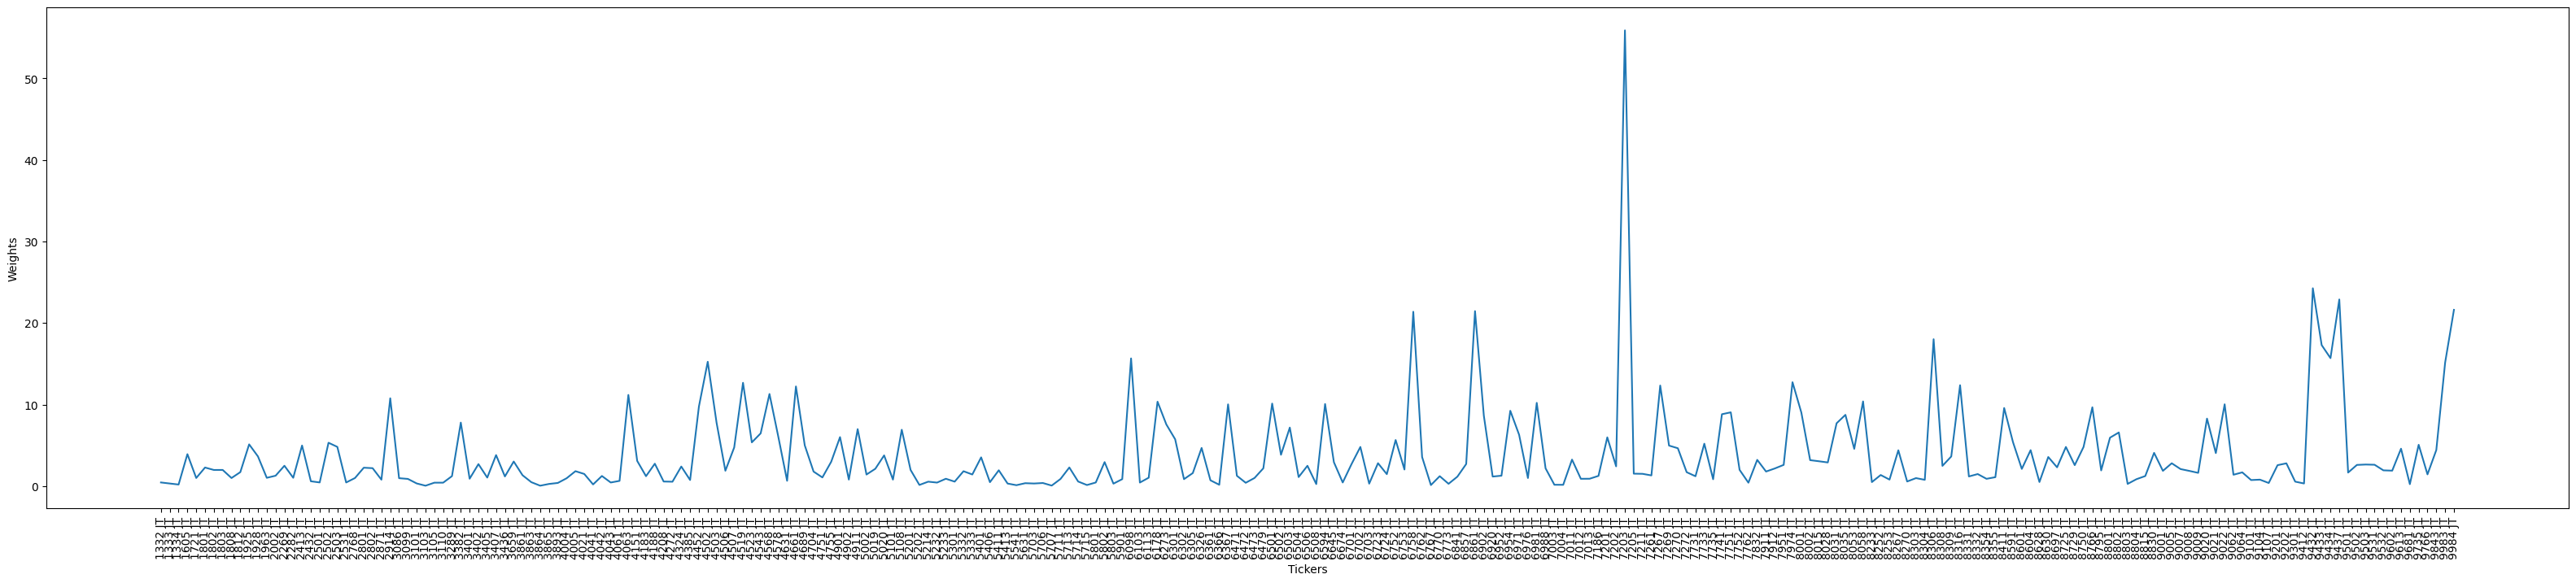

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 8))
plt.plot(df["ticker"], df["weight"])
plt.xlabel("Tickers")
plt.xticks(rotation=90)
plt.ylabel("Weights")
plt.show()

## Task 2

Find out the top 5 index move contributor (both positive and negative) of each day in 2021-01

In [9]:
def calculate_move_contributor(df_last, start, end):
    # Compute price change = (last - prev_price) / prev_price
    df = df_last.copy()
    df.sort_values(['ticker', 'date'], inplace=True)
    df['prev_price'] = df.groupby('ticker')['last'].shift(1)
    df['abs_price_change'] = abs(df['last'] - df['prev_price']) / df['prev_price']
    df.dropna(inplace=True)
        
    # Filter dates
    df_filtered = df[(df["date"] >= start) & (df['date'] <= end)]
        
    # Add weights to dataframe
    df_arr = []
    for i in range ((end - start).days):
        today = start + timedelta(days=i)
        df_arr.append(calculate_index(today, data_mkt_cap))
    
    weight_df = pd.concat(df_arr)
    weight_df.reset_index(drop=True, inplace=True)
    merged_df = pd.merge(df_filtered, weight_df, on=["ticker", "date"])    
    
    # Compute movement = abs_price_change * weight
    merged_df["movement"] = merged_df["abs_price_change"] * merged_df["weight"]
    
    return merged_df

In [10]:
df_move = calculate_move_contributor(data_last, datetime(2021, 1, 1), datetime(2021, 1, 31))

In [11]:
df_move

,ticker,date,last,prev_price,abs_price_change,mkt_cap,weight,movement
0,1332 JT,2021-01-04,388.74,393.35,0.011720,131533.15,0.277332,0.003250
1,1332 JT,2021-01-05,386.89,388.74,0.004759,130908.29,0.276910,0.001318
2,1332 JT,2021-01-06,394.28,386.89,0.019101,133407.73,0.281246,0.005372
3,1332 JT,2021-01-07,395.20,394.28,0.002333,133720.16,0.277240,0.000647
4,1332 JT,2021-01-08,402.59,395.20,0.018699,136219.60,0.277735,0.005193
...,...,...,...,...,...,...,...,...
4954,9984 JT,2021-01-25,8476.95,8610.01,0.015454,18106151.36,36.624113,0.565993
4955,9984 JT,2021-01-26,8477.93,8476.95,0.000116,18108241.17,36.939003,0.004270
4956,9984 JT,2021-01-27,8408.46,8477.93,0.008194,17959864.35,36.438520,0.298585
4957,9984 JT,2021-01-28,8106.13,8408.46,0.035955,17314111.72,35.587041,1.279548


In [12]:
df_move.sort_values(['date', 'movement'], ascending=[True, False], inplace=True)

In [13]:
top_movements_df = pd.concat([x.head(5)[['date', 'ticker', 'movement']] for _, x in df_move.groupby('date')])

In [14]:
top_movements_df = top_movements_df.reset_index(drop=True)

In [15]:
print("Top 5 move contributors for each day")
top_movements_df

Top 5 move contributors for each day


,date,ticker,movement
0,2021-01-04,2413 JT,0.653432
1,2021-01-04,9432 JT,0.571472
2,2021-01-04,4661 JT,0.440360
3,2021-01-04,6758 JT,0.404638
4,2021-01-04,4568 JT,0.366938
...,...,...,...
90,2021-01-29,9984 JT,0.756590
91,2021-01-29,6594 JT,0.676540
92,2021-01-29,7203 JT,0.653097
93,2021-01-29,8035 JT,0.643568


## Task 3

For each sector, create a density plot of daily return of all the stocks in that sector in 2022

In [16]:
def calculate_daily_return(year):
    # Merge data_volume, data_last, data_sector
    merged_data = pd.merge(data_volume, data_last, on=["ticker", "date"])
    merged_data = pd.merge(merged_data, data_sector, on=["ticker"])
    data = merged_data[merged_data.date.dt.year == year]
    
    # Remove rows with 0 volume
    data = data[data["volume"] != 0]
    
    # Compute Volume Weighted Average Price
    data["VWAP"] = data["volume"] * data["last"] / data["volume"]
    
    # Get previous VWAP
    data.sort_values(['ticker', 'date'], inplace=True)
    data["prev_VWAP"] = data.groupby("ticker")["VWAP"].shift(1)
    
    # Compute daily_return = (VWAP - prev_VWAP) / prev_VWAP
    data["daily_return"] = (data["VWAP"] - data["prev_VWAP"]) / data["prev_VWAP"]
    
    return data

In [17]:
df = calculate_daily_return(2022)

In [18]:
df.dropna(inplace=True)

In [19]:
df

,ticker,date,volume,last,bics_sector,VWAP,prev_VWAP,daily_return
1068,1332 JT,2022-01-05,1273400.0,527.13,"Consumer, Non-cyclical",527.13,518.66,0.016331
1069,1332 JT,2022-01-06,2019700.0,517.72,"Consumer, Non-cyclical",517.72,527.13,-0.017851
1070,1332 JT,2022-01-07,1674000.0,513.01,"Consumer, Non-cyclical",513.01,517.72,-0.009098
1071,1332 JT,2022-01-11,1179800.0,514.90,"Consumer, Non-cyclical",514.90,513.01,0.003684
1072,1332 JT,2022-01-12,1139600.0,518.66,"Consumer, Non-cyclical",518.66,514.90,0.007302
...,...,...,...,...,...,...,...,...
420244,9984 JT,2022-12-26,5392700.0,5733.79,Communications,5733.79,5712.95,0.003648
420245,9984 JT,2022-12-27,6626000.0,5751.65,Communications,5751.65,5733.79,0.003115
420246,9984 JT,2022-12-28,7324500.0,5667.30,Communications,5667.30,5751.65,-0.014665
420247,9984 JT,2022-12-29,8281700.0,5575.01,Communications,5575.01,5667.30,-0.016285


Density Plot

In [20]:
import seaborn as sns

In [21]:
sectors = df['bics_sector'].unique()

In [22]:
sectors

array(['Consumer, Non-cyclical', 'Energy', 'Industrial',
       'Consumer, Cyclical', 'Communications', 'Technology', 'Financial',
       'Basic Materials', 'Utilities'], dtype=object)

/var/folders/6n/4q080gyd23s8s04kz4_1dj5w0000gn/T/ipykernel_36219/3708355848.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df["bics_sector"] == "Consumer, Non-cyclical"]["daily_return"], hist=True, kde=False, bins=100, color="blue")


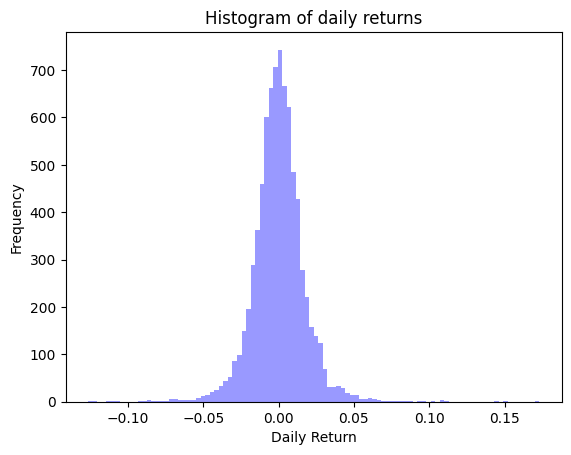

In [23]:
sns.distplot(df[df["bics_sector"] == "Consumer, Non-cyclical"]["daily_return"], hist=True, kde=False, bins=100, color="blue")

plt.title("Histogram of daily returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()